In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.autograd import Variable
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as T


from torch.utils.data import DataLoader
from torch.utils.data import sampler

import numpy as np



In [3]:
NUM_TRAIN = 49000

transform = T.Compose([
                T.ToTensor(),
                T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
            ])

cifar10_train = dset.CIFAR10('./datasets', train=True, download=True,
                             transform=transform)
loader_train = DataLoader(cifar10_train, batch_size=64, 
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

cifar10_val = dset.CIFAR10('./datasets', train=True, download=True,
                           transform=transform)
loader_val = DataLoader(cifar10_val, batch_size=64, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, 50000)))

cifar10_test = dset.CIFAR10('./datasets', train=False, download=True, 
                            transform=transform)
loader_test = DataLoader(cifar10_test, batch_size=64)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [4]:
USE_GPU = True

dtype = torch.float32 

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print_every = 100

print('using device:', device)

using device: cuda


In [11]:
class Flatten(nn.Module):
    def forward(self, x):
        return flatten(x)
    
def train(model, optimizer, epochs=1):

    model = model.to(device=device)
    Loss_list = []
    Accuracy_list = []
    for e in range(epochs):
        for t, (x, y) in enumerate(loader_train):
            model.train()  
            x = x.to(device=device, dtype=dtype)  
            y = y.to(device=device, dtype=torch.long)

            scores = model(x)
            loss = F.cross_entropy(scores, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if t % print_every == 0:
                print('Iteration %d, loss = %.4f' % (t, loss.item()))
                acc,num_correct,num_samples = check_accuracy(loader_val, model)
                print()
        Loss_list.append(loss.item() ) 
        Accuracy_list.append(100 * acc)
def check_accuracy(loader, model):
    if loader.dataset.train:
        print('Checking accuracy on validation set')
    else:
        print('Checking accuracy on test set')   
    num_correct = 0
    num_samples = 0
    model.eval() 
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype) 
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f%%)' % (num_correct, num_samples, 100 * acc))  
        return (acc,num_correct,num_samples)  


In [12]:
model_A = None
optimizer = None

#learning_rate = [0.25,0.1,0.05,0.01]
class AConv(nn.Module):
    def __init__(self,input_size,n_classes=10,**kwargs):
        super(AConv,self).__init__()
        self.conv1 = nn.Conv2d(input_size,96,5,padding=2)
        
        self.pool2 = nn.MaxPool2d(kernel_size=3,stride=2)
        
        self.conv3 = nn.Conv2d(96,192,5,padding=2)
        
        self.pool4 = nn.MaxPool2d(kernel_size=3,stride=2)
        
        
        self.conv5 = nn.Conv2d(192,192,3,padding=1)
        self.conv8 = nn.Conv2d(192,192,1,padding=0)
        self.class_conv = nn.Conv2d(192,n_classes,1,padding=0)
        
        
    def forward(self,x):
        x_drop = F.dropout(x,0.2)
        conv1_out = F.relu(self.conv1(x))
        
        conv3_out = F.relu(self.conv3(F.dropout(self.pool2(conv1_out),0.5)))       
        
        conv5_out = F.relu(self.conv5(F.dropout(self.pool4(conv3_out),0.5)))        
        
        conv8_out = F.relu(self.conv8(conv5_out)) 
        
        class_out = F.relu(self.class_conv(conv8_out))
        
        pool_out = F.avg_pool2d(class_out,kernel_size=6)
        pool_out.squeeze_(-1)
        pool_out.squeeze_(-1)
        
        return pool_out

#for i in range(4):
    #lr = learning_rate[i]
    
model_A = None
optimizer = None
    
model_A = AConv(3)   
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_A.parameters(), lr=0.01,momentum=0.9, weight_decay=0.001,nesterov=True)

#train(model_A, optimizer, epochs=200)   

#optimizer = optim.SGD(model_A.parameters(), lr=lr*0.1,momentum=0.9,weight_decay=0.001,nesterov=True)

#train(model_A, optimizer, epochs=50)

#optimizer = optim.SGD(model_A.parameters(), lr=lr*0.1, momentum=0.9,weight_decay=0.001,nesterov=True)

#train(model_A, optimizer, epochs=50)
#optimizer = optim.SGD(model_A.parameters(), lr=lr*0.1,momentum=0.9,weight_decay=0.001,nesterov=True)

train(model_A, optimizer, epochs=20)
check_accuracy(loader_test, model_A.cuda()) 

Iteration 0, loss = 2.3043
Checking accuracy on validation set
Got 113 / 1000 correct (11.30%)

Iteration 100, loss = 2.1028
Checking accuracy on validation set
Got 238 / 1000 correct (23.80%)

Iteration 200, loss = 2.0637
Checking accuracy on validation set
Got 231 / 1000 correct (23.10%)

Iteration 300, loss = 2.0389
Checking accuracy on validation set
Got 239 / 1000 correct (23.90%)

Iteration 400, loss = 2.0790
Checking accuracy on validation set
Got 287 / 1000 correct (28.70%)

Iteration 500, loss = 1.9954
Checking accuracy on validation set
Got 290 / 1000 correct (29.00%)

Iteration 600, loss = 1.7243
Checking accuracy on validation set
Got 302 / 1000 correct (30.20%)

Iteration 700, loss = 1.7222
Checking accuracy on validation set
Got 356 / 1000 correct (35.60%)

Iteration 0, loss = 1.7803
Checking accuracy on validation set
Got 339 / 1000 correct (33.90%)

Iteration 100, loss = 1.4311
Checking accuracy on validation set
Got 357 / 1000 correct (35.70%)

Iteration 200, loss = 1.

Iteration 400, loss = 0.5144
Checking accuracy on validation set
Got 796 / 1000 correct (79.60%)

Iteration 500, loss = 0.2435
Checking accuracy on validation set
Got 786 / 1000 correct (78.60%)

Iteration 600, loss = 0.6228
Checking accuracy on validation set
Got 789 / 1000 correct (78.90%)

Iteration 700, loss = 0.4689
Checking accuracy on validation set
Got 786 / 1000 correct (78.60%)

Iteration 0, loss = 0.4986
Checking accuracy on validation set
Got 772 / 1000 correct (77.20%)

Iteration 100, loss = 0.6098
Checking accuracy on validation set
Got 792 / 1000 correct (79.20%)

Iteration 200, loss = 0.3904
Checking accuracy on validation set
Got 787 / 1000 correct (78.70%)

Iteration 300, loss = 0.4758
Checking accuracy on validation set
Got 803 / 1000 correct (80.30%)

Iteration 400, loss = 0.4760
Checking accuracy on validation set
Got 772 / 1000 correct (77.20%)

Iteration 500, loss = 0.2786
Checking accuracy on validation set
Got 797 / 1000 correct (79.70%)

Iteration 600, loss = 

(0.8054, tensor(8054, device='cuda:0'), 10000)

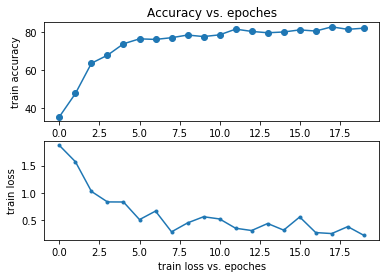

In [13]:
import matplotlib.pyplot as plt
x1 = range(0,20)
x2 = range(0,20)
y1 = Accuracy_list#[x*767 for x in Accuracy_list]
y2 = Loss_list#[x*767 for x in Loss_list]
plt.subplot(2,1,1)
plt.plot(x1, y1, 'o-')
plt.title('Accuracy vs. epoches')
plt.ylabel('train accuracy')
plt.subplot(2, 1, 2)
plt.plot(x2, y2, '.-')
plt.xlabel('train loss vs. epoches')
plt.ylabel('train loss')
plt.show()


In [18]:
model_B = None
optimizer = None
class BConv(nn.Module):
    def __init__(self,input_size,n_classes=10,**kwargs):
        super(BConv,self).__init__()
        self.conv1 = nn.Conv2d(input_size,96,5,padding=2)
        self.conv2 = nn.Conv2d(96,96,1,padding=0)
        
        self.pool3 = nn.MaxPool2d(kernel_size=3,stride=2)
        
        
        self.conv4 = nn.Conv2d(96,192,5,padding=2)
        self.conv5 = nn.Conv2d(192,192,1,padding=0)
        
        self.pool6 = nn.MaxPool2d(kernel_size=3,stride=2)
        
        
        self.conv7 = nn.Conv2d(192,192,3,padding=1)
        self.conv8 = nn.Conv2d(192,192,1,padding=0)
        self.class_conv = nn.Conv2d(192,n_classes,1,padding=0)
        
        
    def forward(self,x):
        
        #add drop
        x_drop = F.dropout(x,0.2)
        conv1_out = F.relu(self.conv1(x_drop))
        conv2_out = F.relu(self.conv2(conv1_out))
        
        conv4_out = F.relu(self.conv4(F.dropout(self.pool3(conv2_out),0.5)))        
        conv5_out = F.relu(self.conv5(conv4_out))
        
        conv7_out = F.relu(self.conv7(F.dropout(self.pool6(conv5_out),0.5)))
        conv8_out = F.relu(self.conv8(conv7_out))   
        class_out = F.relu(self.class_conv(conv8_out))
        
        pool_out = F.avg_pool2d(class_out,kernel_size=6)
        pool_out.squeeze_(-1)
        pool_out.squeeze_(-1)
        
        return pool_out

model_B = BConv(3)
       
loss_fn = nn.CrossEntropyLoss()

optimizer = optim.SGD(model_B.parameters(), lr=0.01,
                     momentum=0.9, weight_decay=0.001 , nesterov=True)

train(model_B, optimizer, epochs=20)        

check_accuracy(loader_test, model_B.cuda())



Iteration 0, loss = 2.2991
Checking accuracy on validation set
Got 127 / 1000 correct (12.70%)

Iteration 100, loss = 2.2988
Checking accuracy on validation set
Got 105 / 1000 correct (10.50%)

Iteration 200, loss = 2.2932
Checking accuracy on validation set
Got 202 / 1000 correct (20.20%)

Iteration 300, loss = 2.2324
Checking accuracy on validation set
Got 213 / 1000 correct (21.30%)

Iteration 400, loss = 2.1691
Checking accuracy on validation set
Got 247 / 1000 correct (24.70%)

Iteration 500, loss = 2.1215
Checking accuracy on validation set
Got 268 / 1000 correct (26.80%)

Iteration 600, loss = 2.0560
Checking accuracy on validation set
Got 303 / 1000 correct (30.30%)

Iteration 700, loss = 1.9257
Checking accuracy on validation set
Got 302 / 1000 correct (30.20%)

Iteration 0, loss = 1.9897
Checking accuracy on validation set
Got 328 / 1000 correct (32.80%)

Iteration 100, loss = 1.9151
Checking accuracy on validation set
Got 348 / 1000 correct (34.80%)

Iteration 200, loss = 1.

Iteration 400, loss = 1.0261
Checking accuracy on validation set
Got 665 / 1000 correct (66.50%)

Iteration 500, loss = 0.7708
Checking accuracy on validation set
Got 650 / 1000 correct (65.00%)

Iteration 600, loss = 0.8550
Checking accuracy on validation set
Got 661 / 1000 correct (66.10%)

Iteration 700, loss = 0.8850
Checking accuracy on validation set
Got 627 / 1000 correct (62.70%)

Iteration 0, loss = 0.7849
Checking accuracy on validation set
Got 665 / 1000 correct (66.50%)

Iteration 100, loss = 0.7862
Checking accuracy on validation set
Got 666 / 1000 correct (66.60%)

Iteration 200, loss = 0.5651
Checking accuracy on validation set
Got 675 / 1000 correct (67.50%)

Iteration 300, loss = 0.7660
Checking accuracy on validation set
Got 675 / 1000 correct (67.50%)

Iteration 400, loss = 0.6365
Checking accuracy on validation set
Got 675 / 1000 correct (67.50%)

Iteration 500, loss = 0.7206
Checking accuracy on validation set
Got 671 / 1000 correct (67.10%)

Iteration 600, loss = 

(0.6982, tensor(6982, device='cuda:0'), 10000)

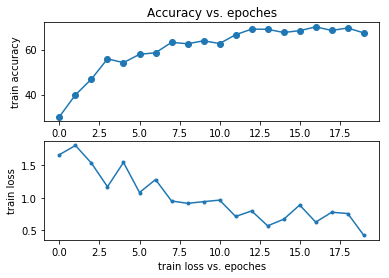

In [19]:
import matplotlib.pyplot as plt
x1 = range(0,20)
x2 = range(0,20)
y1 = Accuracy_list
y2 = Loss_list
plt.subplot(2,1,1)
plt.plot(x1, y1, 'o-')
plt.title('Accuracy vs. epoches')
plt.ylabel('train accuracy')
plt.subplot(2, 1, 2)
plt.plot(x2, y2, '.-')
plt.xlabel('train loss vs. epoches')
plt.ylabel('train loss')
plt.show()


In [ ]:
model_C = None
optimizer = None

class CConv(nn.Module):
    def __init__(self,input_size,n_classes=10,**kwargs):
        super(CConv,self).__init__()
        self.conv1 = nn.Conv2d(input_size,96,3,padding=1)
        self.conv2 = nn.Conv2d(96,96,3,padding=1)
        
        self.pool3 = nn.MaxPool2d(kernel_size=3,stride=2)
        
        self.conv4 = nn.Conv2d(96,192,3,padding=1)
        self.conv5 = nn.Conv2d(192,192,3,padding=1)
        
        self.pool6 = nn.MaxPool2d(kernel_size=3,stride=2)
        
        self.conv7 = nn.Conv2d(192,192,3,padding=1)
        self.conv8 = nn.Conv2d(192,192,1,padding=0)
        self.class_conv = nn.Conv2d(192,n_classes,1,padding=0)
        
        
    def forward(self,x):
        
        #add drop
        x_drop = F.dropout(x,0.2)
        conv1_out = F.relu(self.conv1(x_drop))
        conv2_out = F.relu(self.conv2(conv1_out))
        
        conv4_out = F.relu(self.conv4(F.dropout(self.pool3(conv2_out),0.5)))                    
        conv5_out = F.relu(self.conv5(conv4_out))
        
        conv7_out = F.relu(self.conv7(F.dropout(self.pool6(conv5_out),0.5)))
        conv8_out = F.relu(self.conv8(conv7_out))   
        class_out = F.relu(self.class_conv(conv8_out))
        
        pool_out = F.avg_pool2d(class_out,kernel_size=6)
        pool_out.squeeze_(-1)
        pool_out.squeeze_(-1)
        
        return pool_out

model_C = CConv(3)
       
loss_fn = nn.CrossEntropyLoss()
                           
optimizer = optim.SGD(model_C.parameters(), lr=0.01,
                     momentum=0.9, weight_decay=0.001 ,nesterov=True)

train(model_C, optimizer, epochs=20)        
        
check_accuracy(loader_test, model_C.cuda())

In [ ]:
Loss_list = []
Accuracy_list = []
import matplotlib.pyplot as plt
x1 = range(0,20)
x2 = range(0,20)
y1 = Accuracy_list#[x*767 for x in Accuracy_list]
y2 = Loss_list#[x*767 for x in Loss_list]
plt.subplot(2,1,1)
plt.plot(x1, y1, 'o-')
plt.title('Accuracy vs. epoches')
plt.ylabel('train accuracy')
plt.subplot(2, 1, 2)
plt.plot(x2, y2, '.-')
plt.xlabel('train loss vs. epoches')
plt.ylabel('train loss')
plt.show()

In [ ]:
model_STRIDED = None
optimizer = None

class STRIDED(nn.Module):
    def __init__(self,input_size,n_classes=10,**kwargs):
        super(STRIDED,self).__init__()
        self.conv1 = nn.Conv2d(input_size,96,3,padding=1)
        self.conv2 = nn.Conv2d(96,96,3,stride=2,padding=1)
        
        self.conv3 = nn.Conv2d(96,192,3,padding=1)
        self.conv4 = nn.Conv2d(192,192,3,stride=2,padding=1)
        
        self.conv5 = nn.Conv2d(192,192,3,padding=1)
        self.conv6 = nn.Conv2d(192,192,1,padding=0)
        self.class_conv = nn.Conv2d(192,n_classes,1,padding=0)
        
        
    def forward(self,x):
        
        #add drop
        x_drop = F.dropout(x,0.2)
        conv1_out = F.relu(self.conv1(x_drop))
        conv2_out = F.relu(self.conv2(conv1_out))
        conv2_out = F.dropout(conv2_out,0.5)
        
        conv3_out = F.relu(self.conv3(conv2_out))
        conv4_out = F.relu(self.conv4(conv3_out))
        conv4_out = F.dropout(conv4_out,0.5)
        
        conv5_out = F.relu(self.conv5(conv4_out))
        conv6_out = F.relu(self.conv6(conv5_out))
        
        class_out = F.relu(self.class_conv(conv6_out))
        
        pool_out = F.avg_pool2d(class_out,kernel_size=6)
        pool_out.squeeze_(-1)
        pool_out.squeeze_(-1)
        
        return pool_out

model_STRIDED = STRIDED(3)
       
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_STRIDED.parameters(), lr=0.01,
                     momentum=0.9,  weight_decay=0.001 ,nesterov=True)

train(model_STRIDED, optimizer, epochs=20) 

check_accuracy(loader_test, model_STRIDED.cuda())

In [ ]:
Loss_list = []
Accuracy_list = []
import matplotlib.pyplot as plt
x1 = range(0,20)
x2 = range(0,20)
y1 = Accuracy_list#[x*767 for x in Accuracy_list]
y2 = Loss_list#[x*767 for x in Loss_list]
plt.subplot(2,1,1)
plt.plot(x1, y1, 'o-')
plt.title('Accuracy vs. epoches')
plt.ylabel('train accuracy')
plt.subplot(2, 1, 2)
plt.plot(x2, y2, '.-')
plt.xlabel('train loss vs. epoches')
plt.ylabel('train loss')
plt.show()

In [ ]:
model_ConvP = None
optimizer = None
from torch.nn import init
class ConvP(nn.Module):
    def __init__(self,input_size,n_classes=10,**kwargs):
        super(ConvP,self).__init__()
        self.conv1 = nn.Conv2d(input_size,96,3,padding=1,bias=True)
        init.xavier_uniform(self.conv1.weight, gain=np.sqrt(2.0))
        init.constant(self.conv1.bias, 0.1)
        
        self.conv2 = nn.Conv2d(96,96,3,padding=1)
        init.xavier_uniform(self.conv2.weight, gain=np.sqrt(2.0))
        init.constant(self.conv2.bias, 0.1)
        
        self.conv3 = nn.Conv2d(96,96,3,padding=1)
        init.xavier_uniform(self.conv3.weight, gain=np.sqrt(2.0))
        init.constant(self.conv3.bias, 0.1)
        
        self.pool4 = nn.MaxPool2d(kernel_size=3,stride=2)
        
        self.conv5 = nn.Conv2d(96,192,3,padding=1)
        self.conv6 = nn.Conv2d(192,192,3,padding=1)
        self.conv7 = nn.Conv2d(192,192,3,padding=1)
        
        self.pool8 = nn.MaxPool2d(kernel_size=3,stride=2)
        self.conv9 = nn.Conv2d(192,192,3,padding=1)
        self.conv10 = nn.Conv2d(192,192,1,padding=0)
        self.class_conv = nn.Conv2d(192,n_classes,1,padding=0)
    def forward(self,x):
        #add drop
        x_drop = F.dropout(x,0.2)
        conv1_out = F.relu(self.conv1(x_drop))
        conv2_out = F.relu(self.conv2(conv1_out))
        conv3_out = F.relu(self.conv3(conv2_out))
        
        conv5_out = F.relu(self.conv5(F.dropout(self.pool4(conv3_out),0.5)))             
        conv6_out = F.relu(self.conv6(conv5_out))
        conv7_out = F.relu(self.conv7(conv6_out))
        
        conv9_out = F.relu(self.conv9(F.dropout(self.pool8(conv7_out),0.5)))  
        conv10_out = F.relu(self.conv10(conv9_out))
        
        class_out = F.relu(self.class_conv(conv10_out))
        
        pool_out = F.avg_pool2d(class_out,kernel_size=6)
        pool_out.squeeze_(-1)
        pool_out.squeeze_(-1)
        
        return pool_out

model_ConvP = ConvP(3)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_ConvP.parameters(), lr=0.01,
                     momentum=0.9, weight_decay=0.001 ,nesterov=True)

train(model_ConvP, optimizer, epochs=20) 

check_accuracy(loader_test, model_ConvP.cuda())

In [ ]:
Loss_list = []
Accuracy_list = []
import matplotlib.pyplot as plt
x1 = range(0,20)
x2 = range(0,20)
y1 = Accuracy_list#[x*767 for x in Accuracy_list]
y2 = Loss_list#[x*767 for x in Loss_list]
plt.subplot(2,1,1)
plt.plot(x1, y1, 'o-')
plt.title('Accuracy vs. epoches')
plt.ylabel('train accuracy')
plt.subplot(2, 1, 2)
plt.plot(x2, y2, '.-')
plt.xlabel('train loss vs. epoches')
plt.ylabel('train loss')
plt.show()

In [34]:
model_ALLC = None
optimizer = None
from torch.nn import init
class ALLC(nn.Module):
    def __init__(self,input_size,n_classes=10,**kwargs):
        super(ALLC,self).__init__() 
        self.conv1 = nn.Conv2d(input_size,96,3,padding=1)
        init.xavier_uniform(self.conv1.weight, gain=np.sqrt(2.0))
        init.constant(self.conv1.bias, 0.1) 
        self.conv2 = nn.Conv2d(96,96,3,padding=1)
        init.xavier_uniform(self.conv2.weight, gain=np.sqrt(2.0))
        init.constant(self.conv2.bias, 0.1)

        self.conv3 = nn.Conv2d(96,96,3,padding=1,stride=2)
        init.xavier_uniform(self.conv3.weight, gain=np.sqrt(2.0))
        init.constant(self.conv3.bias, 0.1)
        
        self.conv4 = nn.Conv2d(96,192,3,padding=1)
        init.xavier_uniform(self.conv4.weight, gain=np.sqrt(2.0))
        init.constant(self.conv4.bias, 0.1)
        
        self.conv5 = nn.Conv2d(192,192,3,padding=1)  
        self.conv6 = nn.Conv2d(192,192,3,padding=1,stride=2)
        self.conv7 = nn.Conv2d(192,192,3,padding=1)
        self.conv8 = nn.Conv2d(192,192,1,padding=0)
        self.class_conv = nn.Conv2d(192,n_classes,1,padding=0)
    def forward(self,x): 
        #add drop
        x_drop = F.dropout(x,0.2)
        conv1_out = F.relu(self.conv1(x_drop))
        conv2_out = F.relu(self.conv2(conv1_out))
        conv3_out = F.relu(self.conv3(conv2_out))
        
        conv3_out = F.dropout(conv3_out,0.5)
        
        conv4_out = F.relu(self.conv4(conv3_out)) 
        conv5_out = F.relu(self.conv5(conv4_out))
        conv6_out = F.relu(self.conv6(conv5_out))
        
        conv6_out = F.dropout(conv6_out,0.5)
        
        conv7_out = F.relu(self.conv7(conv6_out)) 
        conv8_out = F.relu(self.conv8(conv7_out))
        class_out = F.relu(self.class_conv(conv8_out))
        
        pool_out = F.avg_pool2d(class_out,kernel_size=6)
        pool_out.squeeze_(-1)
        pool_out.squeeze_(-1)
        
        return pool_out

model_ALLC = ALLC(3)
       
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_ALLC.parameters(), lr=0.01,
                     momentum=0.9,weight_decay=0.001,nesterov=True)

train(model_ALLC, optimizer, epochs=20) 
check_accuracy(loader_test, model_ALLC.cuda())

Iteration 0, loss = 2.3033
Checking accuracy on validation set


/home/wx/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  # This is added back by InteractiveShellApp.init_path()
/home/wx/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  if sys.path[0] == '':
/home/wx/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  from ipykernel import kernelapp as app
/home/wx/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  app.launch_new_instance()
/home/wx/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
/home/wx/anaconda3/lib/python3.7/site-packages/ipyker

Got 112 / 1000 correct (11.20%)

Iteration 100, loss = 2.3014
Checking accuracy on validation set
Got 122 / 1000 correct (12.20%)

Iteration 200, loss = 2.1879
Checking accuracy on validation set
Got 160 / 1000 correct (16.00%)

Iteration 300, loss = 2.2372
Checking accuracy on validation set
Got 170 / 1000 correct (17.00%)

Iteration 400, loss = 2.1670
Checking accuracy on validation set
Got 255 / 1000 correct (25.50%)

Iteration 500, loss = 2.0966
Checking accuracy on validation set
Got 270 / 1000 correct (27.00%)

Iteration 600, loss = 2.1785
Checking accuracy on validation set
Got 317 / 1000 correct (31.70%)

Iteration 700, loss = 1.8037
Checking accuracy on validation set
Got 337 / 1000 correct (33.70%)

Iteration 0, loss = 1.8361
Checking accuracy on validation set
Got 333 / 1000 correct (33.30%)

Iteration 100, loss = 1.5695
Checking accuracy on validation set
Got 334 / 1000 correct (33.40%)

Iteration 200, loss = 1.6124
Checking accuracy on validation set
Got 349 / 1000 correct

Got 754 / 1000 correct (75.40%)

Iteration 500, loss = 0.7438
Checking accuracy on validation set
Got 724 / 1000 correct (72.40%)

Iteration 600, loss = 0.7187
Checking accuracy on validation set
Got 759 / 1000 correct (75.90%)

Iteration 700, loss = 0.8174
Checking accuracy on validation set
Got 767 / 1000 correct (76.70%)

Iteration 0, loss = 0.4511
Checking accuracy on validation set
Got 744 / 1000 correct (74.40%)

Iteration 100, loss = 0.6062
Checking accuracy on validation set
Got 761 / 1000 correct (76.10%)

Iteration 200, loss = 0.8505
Checking accuracy on validation set
Got 734 / 1000 correct (73.40%)

Iteration 300, loss = 0.5124
Checking accuracy on validation set
Got 748 / 1000 correct (74.80%)

Iteration 400, loss = 0.6082
Checking accuracy on validation set
Got 764 / 1000 correct (76.40%)

Iteration 500, loss = 0.4851
Checking accuracy on validation set
Got 755 / 1000 correct (75.50%)

Iteration 600, loss = 0.6996
Checking accuracy on validation set
Got 774 / 1000 correct

In [43]:
torch.save(model_ALLC.state_dict(),'model_ALLC.pkl')